## import data

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [3]:
train_data = pd.read_csv("data/train_data.csv")

In [4]:
train_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


## Visualize data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# データの統計量を表示
print("\n数値特徴量の基本統計量:")
print(train_data.describe())

# カテゴリ変数のユニーク値と頻度を確認
print("\nカテゴリ変数のユニーク値:")
for col in train_data.select_dtypes(include='object').columns:
    print(f"{col}: {train_data[col].nunique()} 個")
    print(train_data[col].value_counts().head())
    print()


数値特徴量の基本統計量:
       SeniorCitizen       tenure  MonthlyCharges
count    5634.000000  5634.000000     5634.000000
mean        0.160809    32.373092       64.864253
std         0.367388    24.424539       30.089324
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.750000
50%         0.000000    29.000000       70.525000
75%         0.000000    55.000000       89.937500
max         1.000000    72.000000      118.600000

カテゴリ変数のユニーク値:
customerID: 5634 個
customerID
4795-UXVCJ    1
4223-BKEOR    1
2876-GZYZC    1
9365-SRSZE    1
3137-NYQQI    1
Name: count, dtype: int64

gender: 2 個
gender
Male      2887
Female    2747
Name: count, dtype: int64

Partner: 2 個
Partner
No     2904
Yes    2730
Name: count, dtype: int64

Dependents: 2 個
Dependents
No     3951
Yes    1683
Name: count, dtype: int64

PhoneService: 2 個
PhoneService
Yes    5082
No      552
Name: count, dtype: int64

MultipleLines: 3 個
MultipleLines
No                  2685
Yes               


数値特徴量の分布:


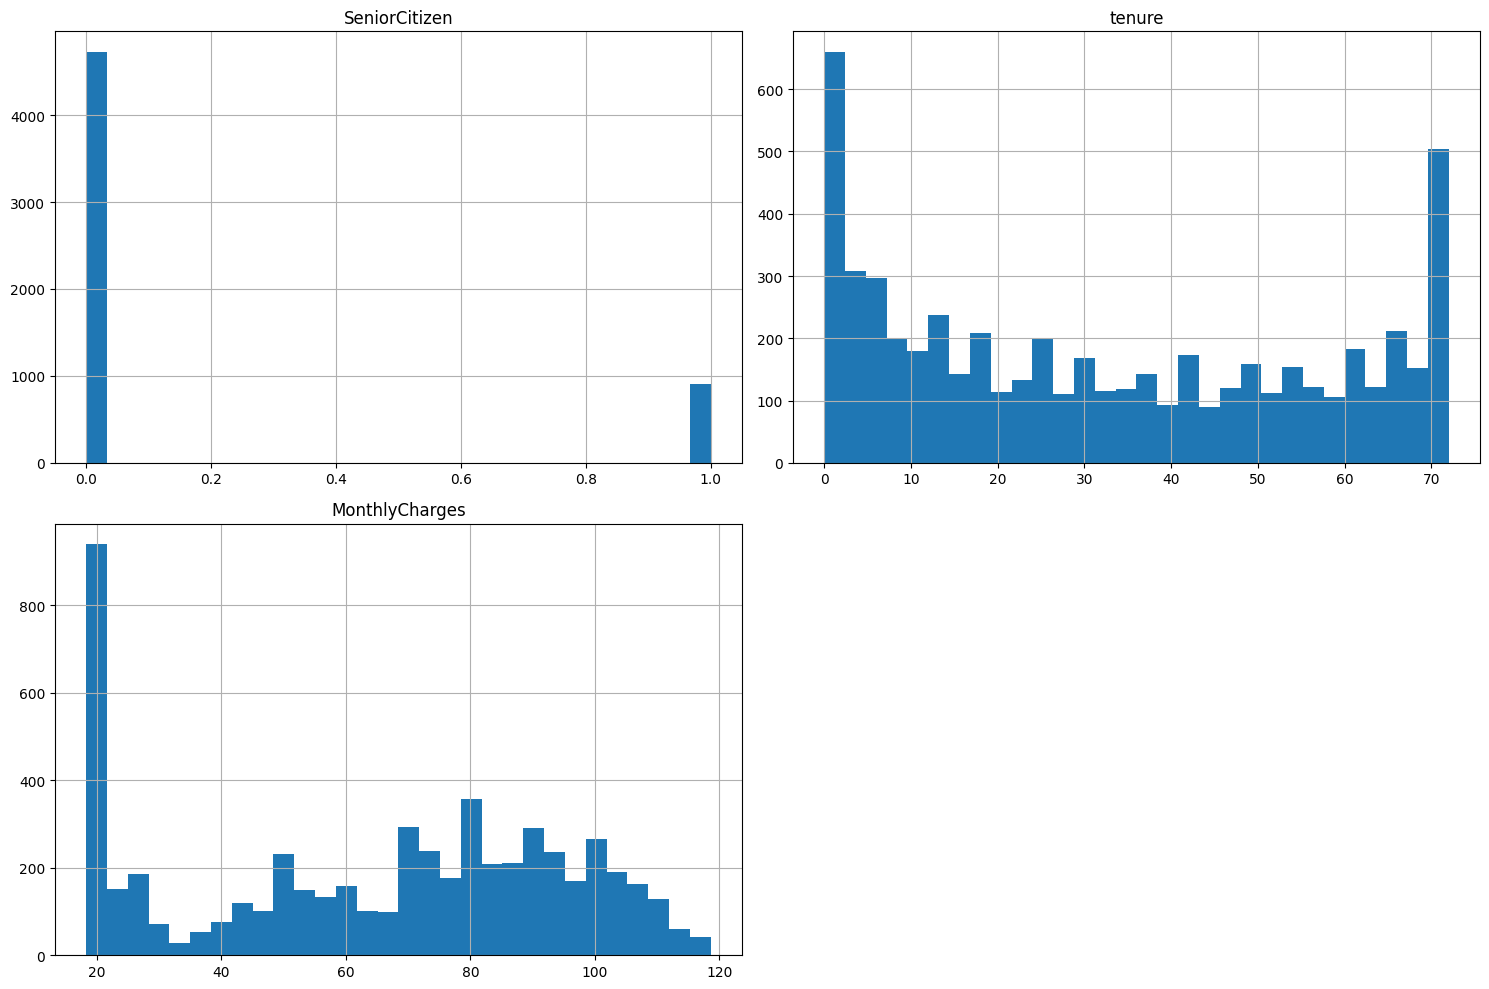

In [19]:
# 数値特徴量のヒストグラムを表示
print("\n数値特徴量の分布:")
numeric_data = train_data.select_dtypes(include=['number'])

# 数値特徴量のヒストグラム
numeric_data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


カテゴリ特徴量の分布:


/tmp/ipykernel_2200/2054414382.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(bins=30, ax=ax)


/tmp/ipykernel_2200/2054414382.py:20: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


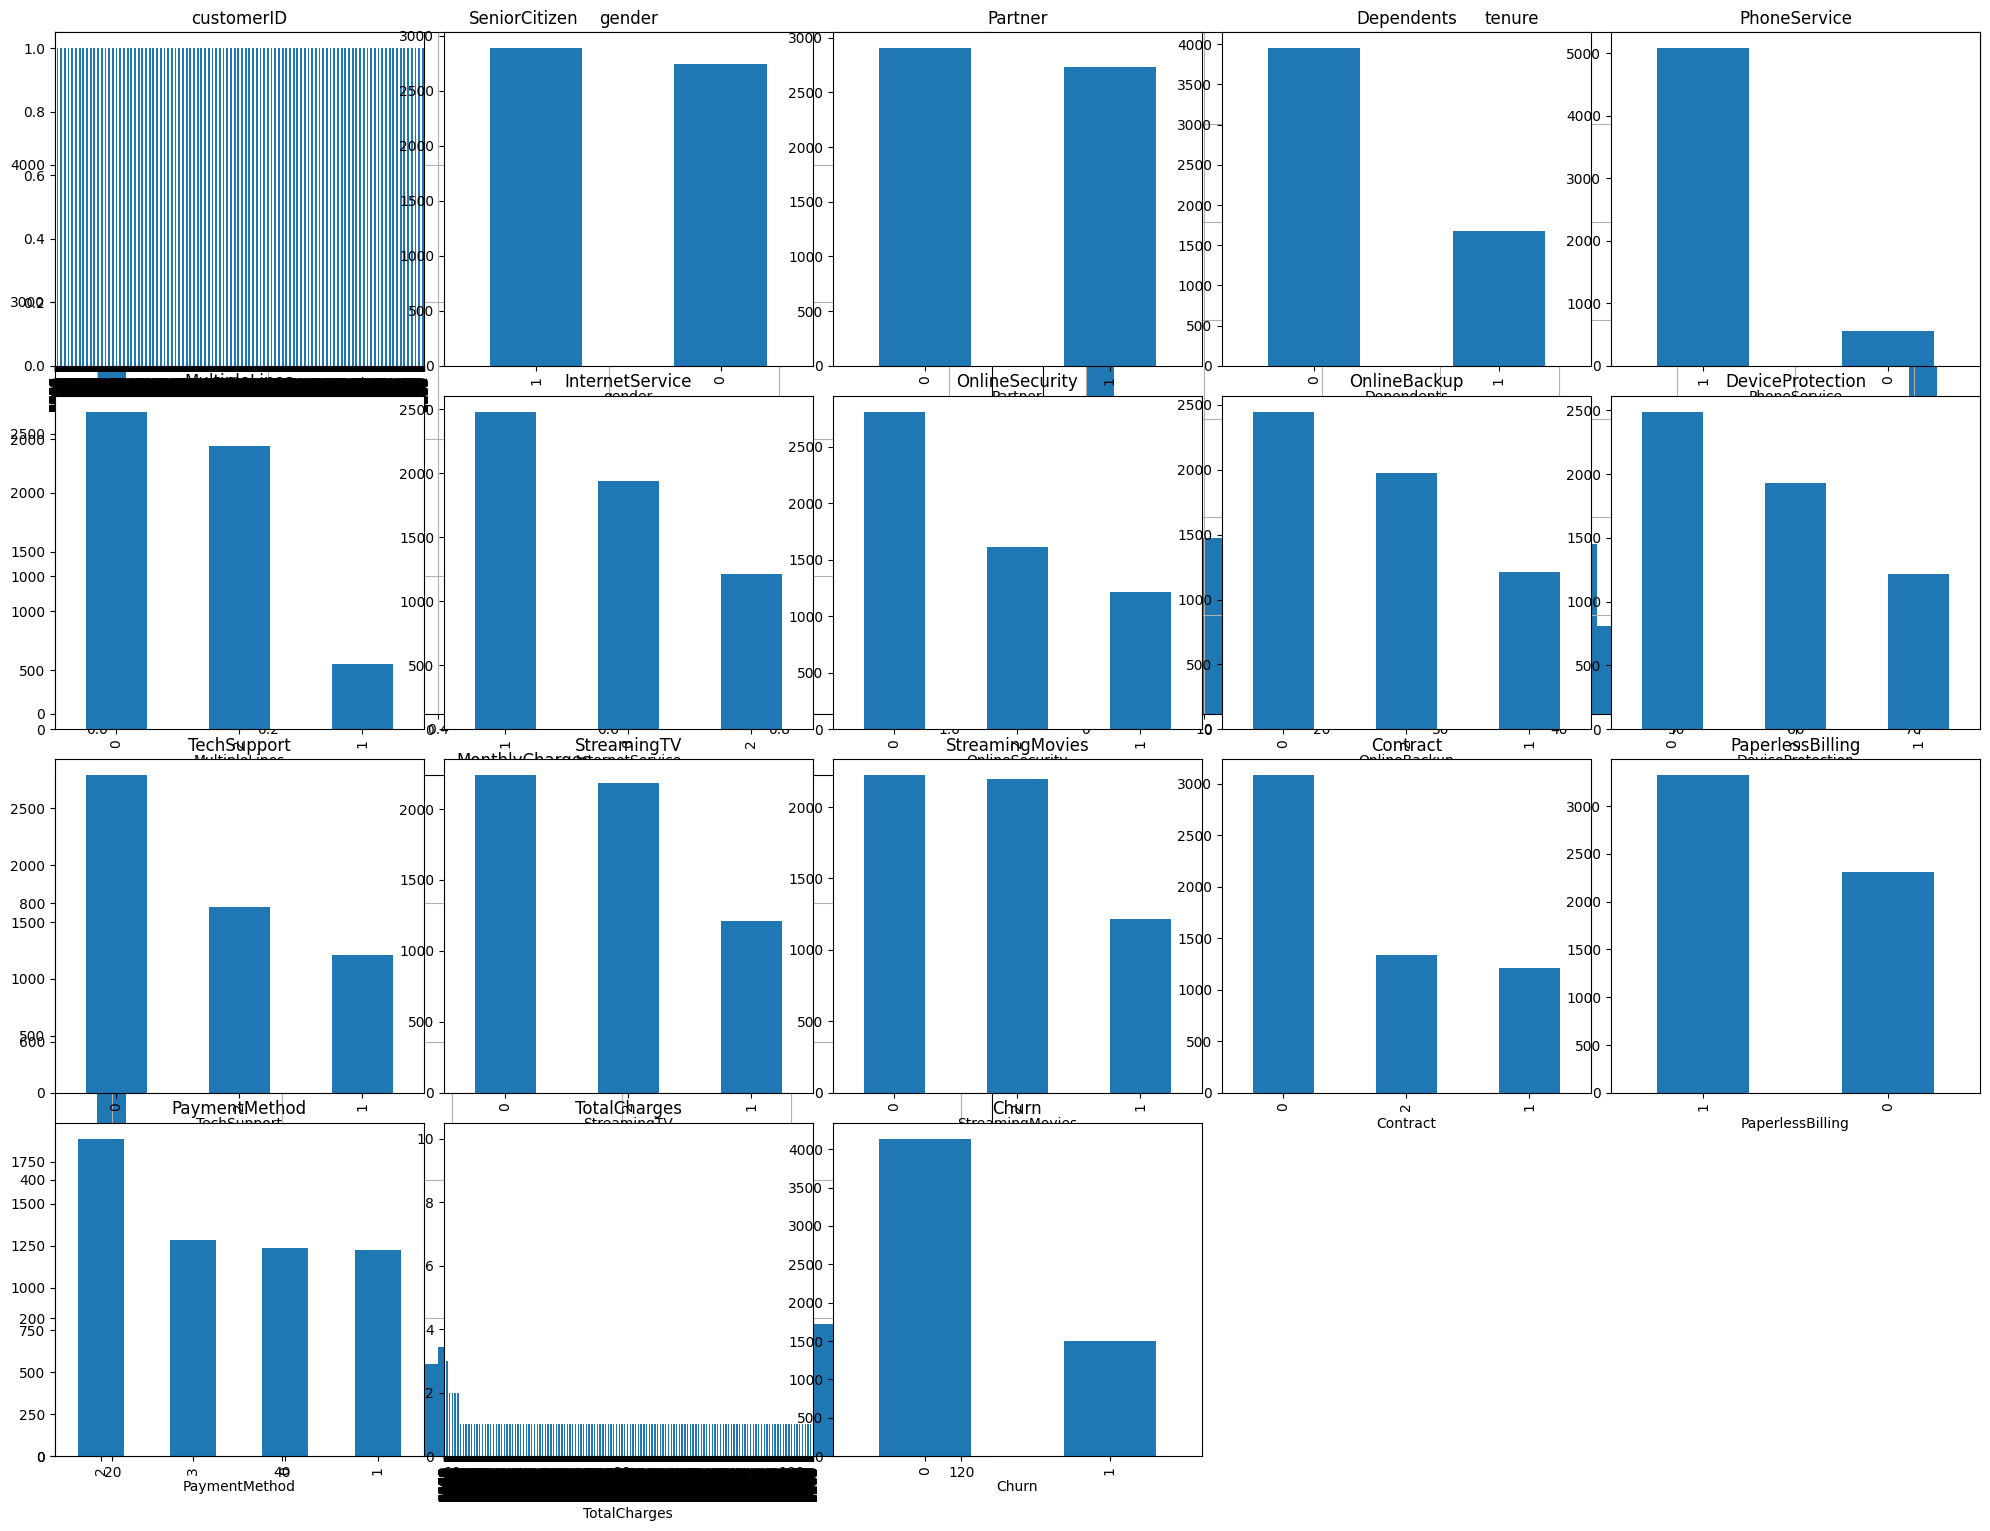

In [25]:
# カテゴリ特徴量のエンコーディングと分布
print("\nカテゴリ特徴量の分布:")
categorical_data = train_data.select_dtypes(include=['object'])

# ラベルエンコーディングを実行
encoded_data = categorical_data.apply(LabelEncoder().fit_transform)

# プロットの作成 (数値特徴量とカテゴリ特徴量を1つの枠に収める)
fig, ax = plt.subplots(figsize=(20, 15))

# 数値特徴量をヒストグラムで表示
numeric_data.hist(bins=30, ax=ax)
plt.tight_layout()

# カテゴリ変数の分布を棒グラフとして表示
for i, column in enumerate(encoded_data.columns):
    ax = plt.subplot(4, 5, i + 1)
    encoded_data[column].value_counts().plot(kind='bar', ax=ax, title=f'{column}')

plt.tight_layout()
plt.show()

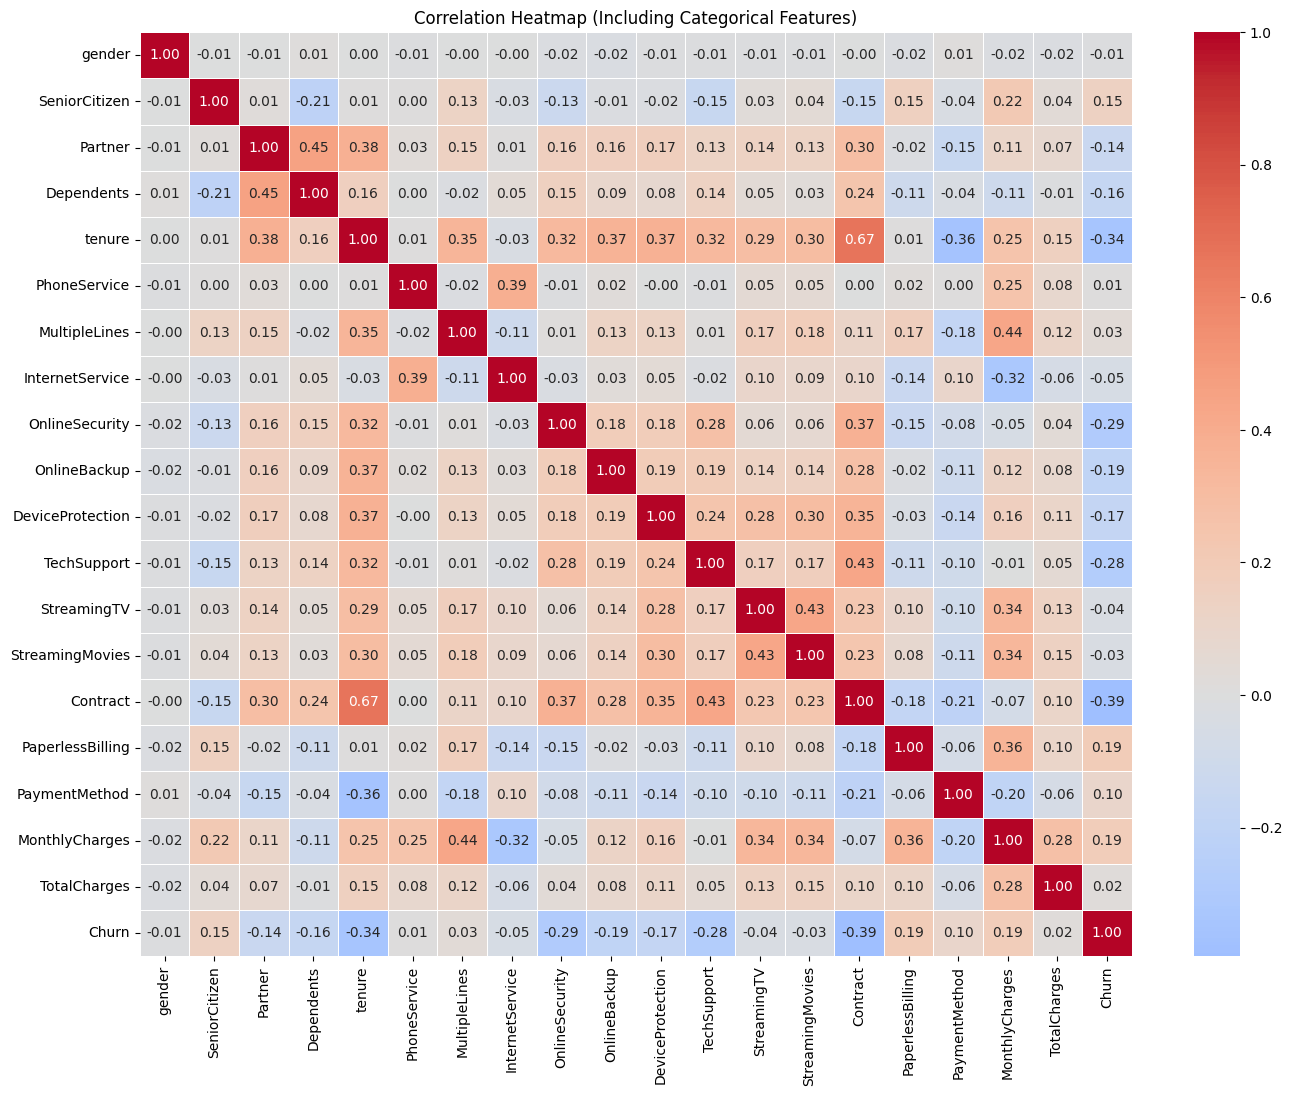

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# カテゴリ変数同士の相関をCramér's Vで計算
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# 相関行列の作成（カテゴリ変数の処理を含む）
def compute_corr(X, categorical_cols):
    # カテゴリ変数のエンコーディング
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])
    
    # 数値データの相関行列
    corr = X.corr()

    # カテゴリ変数同士の相関を計算（Cramér's V）
    cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                    columns=categorical_cols, index=categorical_cols)
    
    for i, col1 in enumerate(categorical_cols):
        for j, col2 in enumerate(categorical_cols):
            if i < j:
                cramers_v_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])
                cramers_v_matrix.loc[col2, col1] = cramers_v_matrix.loc[col1, col2]
    
    return corr, cramers_v_matrix

# 目標変数 'Churn' と特徴量を分ける
X = train_data.drop(columns=['customerID'])  # 'customerID' は削除（個別識別子なので予測に使わない）

# カテゴリ変数のカラムを取得
categorical_cols = X.select_dtypes(include=['object']).columns

# 相関を計算
corr, cramers_v_matrix = compute_corr(X, categorical_cols)

# 数値データの相関行列とカテゴリ変数同士のCramér's Vを結合
full_corr = pd.concat([corr, cramers_v_matrix], axis=1, join='outer')

# 相関行列をヒートマップで可視化
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap (Including Categorical Features)')
plt.show()

## データの前処理

## モデル開発

In [18]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 目標変数 'Churn' と特徴量を分ける
X = train_data.drop(columns=['Churn', 'customerID'])  # 'customerID' は削除（個別識別子なので予測に使わない）
y = train_data['Churn']

# ラベルエンコーディング（カテゴリ変数の処理）
le = LabelEncoder()

# 'Churn'列の 'Yes'/'No' を 1/0 に変換
y = le.fit_transform(y)

# 'TotalCharges'が文字列の場合、数値に変換
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

# カテゴリ変数のカラムを取得
categorical_cols = X.select_dtypes(include=['object']).columns

# カテゴリ変数をラベルエンコード（数値に変換）
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# StratifiedKFoldを使用して、クロスバリデーションを実行
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LightGBMのモデルを作成
lgb_model = lgb.LGBMClassifier()

# パラメータグリッドを定義（チューニングしたいハイパーパラメータを指定）
param_grid = {
    'num_leaves': [31, 50, 100],         # 木の葉の数
    'max_depth': [-1, 10, 20],           # 最大深さ
    'learning_rate': [0.05, 0.1, 0.2],   # 学習率
    'n_estimators': [100, 200],          # 木の数
    'subsample': [0.8, 1.0],             # サブサンプリングの割合
    'colsample_bytree': [0.8, 1.0]       # 木ごとの特徴量サブサンプリング
}

# GridSearchCVを使用してハイパーパラメータをチューニング
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)

# グリッドサーチを実行
grid_search.fit(X, y)

# 最良のパラメータを表示
print(f"最良のパラメータ: {grid_search.best_params_}")

# 最良のモデルで予測
best_model = grid_search.best_estimator_

# 検証データを使って予測（再度分割したデータを使用することができます）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_model.predict(X_val)

# 精度の評価
accuracy = accuracy_score(y_val, y_pred)
print(f"最良モデルの検証データに対する精度: {accuracy:.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265587 -> initscore=-1.017130
[LightGBM] [Info] Start training from score -1.017130
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train s